**TIỀN XỬ LÝ DỮ LIỆU**



*   Import các thư viện cần thiết



In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math



*   Đọc dữ liệu từ file csv



In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XOM.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100




*   Trực quan hóa lịch sử giá cổ phiếu


Text(0, 0.5, 'Prices ($)')

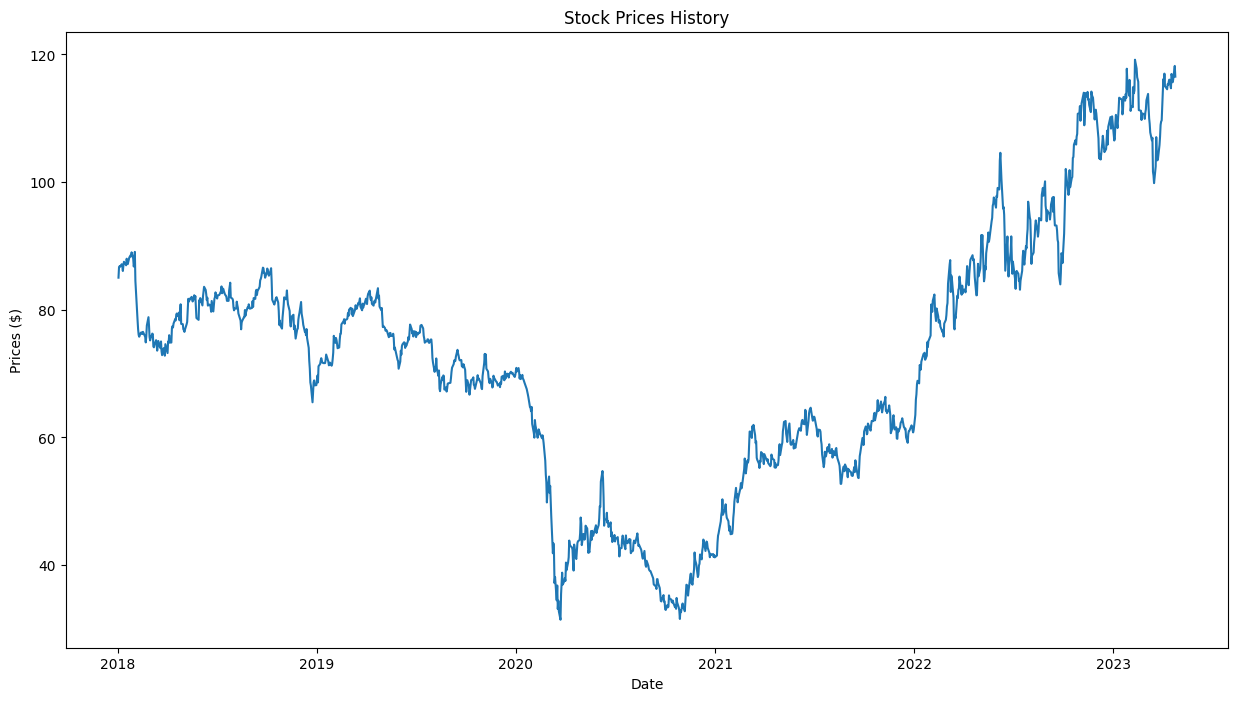

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')




*   Chuẩn hóa dữ liệu bằng phương pháp MinMaxScaler




In [5]:
close_prices = data['Close']
values = close_prices.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))



*   Tách dữ liệu thành 3 phần train, test và validation theo tỉ lệ 7:2:1




In [7]:
train_size = int(len(scaled_data) * 0.7)
test_size = int(len(scaled_data) * 0.2)
validation_size = len(scaled_data) - train_size - test_size

train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-60:train_size+test_size, :]
validation_data = scaled_data[train_size+test_size-60:, :]

In [8]:
print(len(values))
print(len(scaled_data))

print(train_size)
print(test_size)
print(validation_size)

print(len(train_data))
print(len(test_data))
print(len(validation_data))

1337
1337
935
267
135
935
327
195




*   Tạo dữ liệu train



In [9]:
# Train data
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)


In [10]:
x_train.shape,y_train.shape

((875, 60), (875,))



*   Tạo dữ liệu test



In [11]:
# Test data
x_test = []
y_test = []
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
  y_test.append(test_data[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

In [12]:
x_test.shape, y_test.shape

((267, 60), (267,))



*   Tạo dữ liệu validation



In [13]:
# Validation data
x_validation = []
y_validation = []
for i in range(60, len(validation_data)):
  x_validation.append(validation_data[i-60:i, 0])
  y_validation.append(validation_data[i, 0])

x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

In [14]:
x_validation.shape, y_validation.shape

((135, 60), (135,))



*   Reshape dữ liệu train, validation, test



In [15]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_validation = np.reshape(x_validation, (x_validation.shape[0], x_validation.shape[1], 1))

**XÂY DỰNG MÔ HÌNH LSTM**



*   Import các thư viện cần thiết


In [16]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [17]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 206,701
Trainable params: 206,701
Non-trainable params: 0
_________________________________________________________________


**HUẤN LUYỆN MÔ HÌNH**

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=2, epochs=5)

Epoch 1/5
438/438 [==============================] - 72s 149ms/step - loss: 0.0027
Epoch 2/5
438/438 [==============================] - 65s 148ms/step - loss: 0.0012
Epoch 3/5
438/438 [==============================] - 67s 154ms/step - loss: 7.6618e-04
Epoch 4/5
438/438 [==============================] - 77s 176ms/step - loss: 6.3981e-04
Epoch 5/5
438/438 [==============================] - 71s 161ms/step - loss: 5.1821e-04


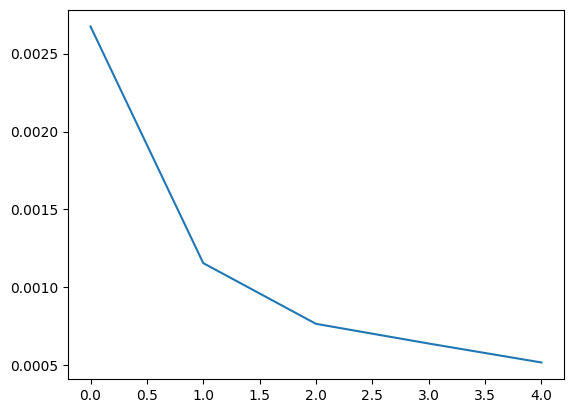

In [19]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

**HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH DỰA TRÊN DỮ LIỆU TEST**



*   Dự đoán trên dữ liệu test



In [20]:
y_test_pred = model.predict(x_test)

9/9 [==============================] - 2s 51ms/step




*   Đưa kết quả về dạng gốc



In [21]:
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))



*   Đánh giá mô hình (Tính toán RMSE trên dữ liệu test)



In [22]:
rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
print('RMSE on test data:', rmse_test)

RMSE on test data: 2.3178079949058747


**HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH DỰA TRÊN DỮ LIỆU VALIDATION**



*   Dự đoán trên dữ liệu validation



In [23]:
y_validation_pred = model.predict(x_validation)

5/5 [==============================] - 0s 44ms/step




*   Đưa kết quả về dạng gốc



In [24]:
y_validation_pred = scaler.inverse_transform(y_validation_pred)
y_validation = scaler.inverse_transform(y_validation.reshape(-1, 1))



*   Đánh giá mô hình (Tính toán RMSE trên dữ liệu validation)



In [25]:
rmse_validation = np.sqrt(np.mean((y_validation_pred - y_validation)**2))
print('RMSE on validation data:', rmse_validation)

RMSE on validation data: 2.3637680610420273


**TRỰC QUAN HÓA DỰ ĐOÁN**



*   Biểu đồ 1


<ipython-input-27-27dca6b330c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = y_test_pred
<ipython-input-27-27dca6b330c1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = y_validation_pred


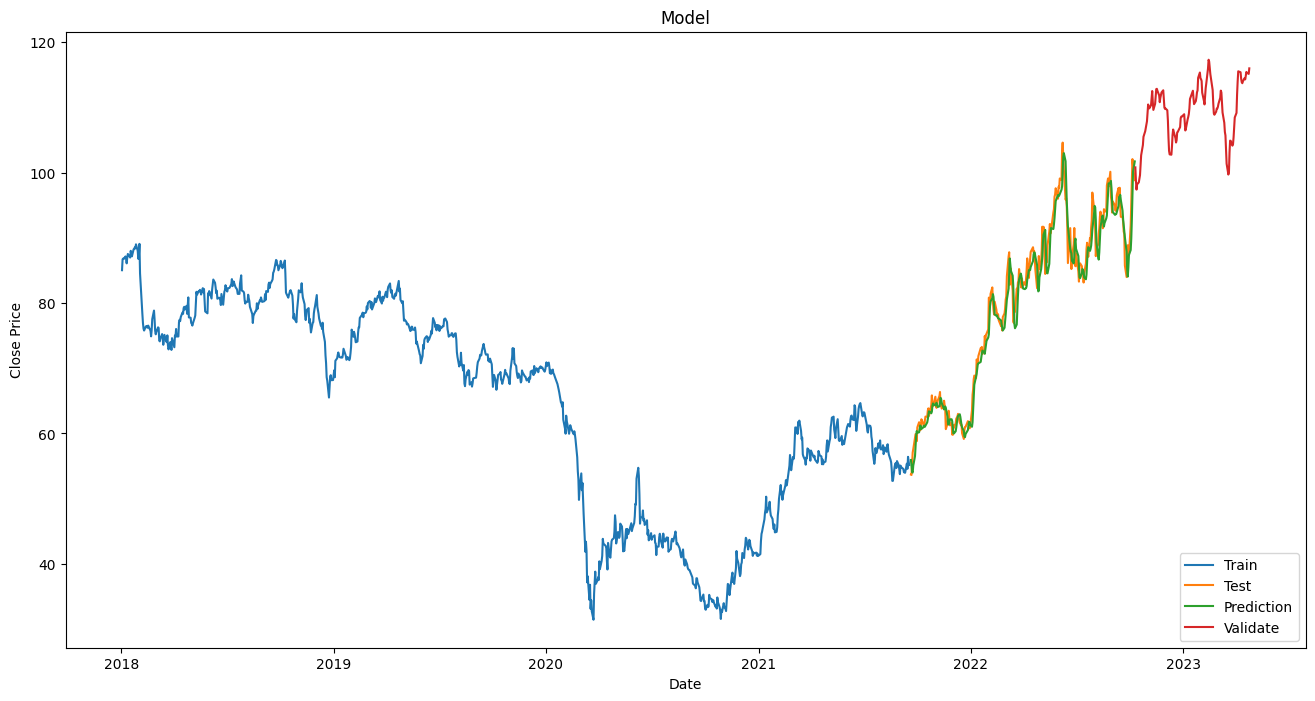

In [27]:
data = data.filter(['Close'])
train = data[:train_size]
test = data[train_size:train_size+test_size]
validation = data[train_size+test_size:]
test['Predictions'] = y_test_pred
validation['Predictions'] = y_validation_pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(test[['Close', 'Predictions']])
plt.plot(validation[['Predictions']])
plt.legend(['Train', 'Test', 'Prediction','Validate'], loc='lower right')
plt.show()


*   Biểu đồ 2



In [31]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

x_train_ind = list(range(0, train_size))
x_test_ind = list(range(train_size, train_size+test_size))
x_validation_ind = list(range(train_size+test_size, len(values)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train_ind, y=train['Close'], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=x_test_ind,y=test['Close'], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=x_test_ind,y=test['Predictions'], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=x_validation_ind, y=validation['Predictions'], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'XOM LSTM data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [27]:
len(test)

133

**DỰ ĐOÁN CHO 30 NGÀY TIẾP THEO TRONG TƯƠNG LAI**

*Cách 1*

In [32]:
# Dữ liệu mới
future_data = scaled_data[-60:, :]  # Lấy 60 ngày gần nhất

# Dự đoán giá đóng trong 30 ngày tiếp theo
y_future_pred = []
x_future = np.array([future_data])  # Chuyển thành mảng 3D (1 mẫu, 60 time steps, 1 đặc trưng)
for _ in range(30):
    y_pred = model.predict(x_future)
    y_future_pred.append(y_pred[0, 0])
    future_data = np.roll(future_data, -1, axis=0)  # Dịch chuyển dữ liệu qua trái 1 time step
    future_data[-1, 0] = y_pred[0, 0]  # Cập nhật giá dự đoán vào dữ liệu mới
    x_future = np.array([future_data])

# Chuyển đổi giá trị dự đoán về đơn vị ban đầu
y_future_pred = scaler.inverse_transform(np.array(y_future_pred).reshape(-1, 1))

1/1 [==============================] - 0s 34ms/step




*   Biểu đồ thể hiện kết quả dự đoán tương lai


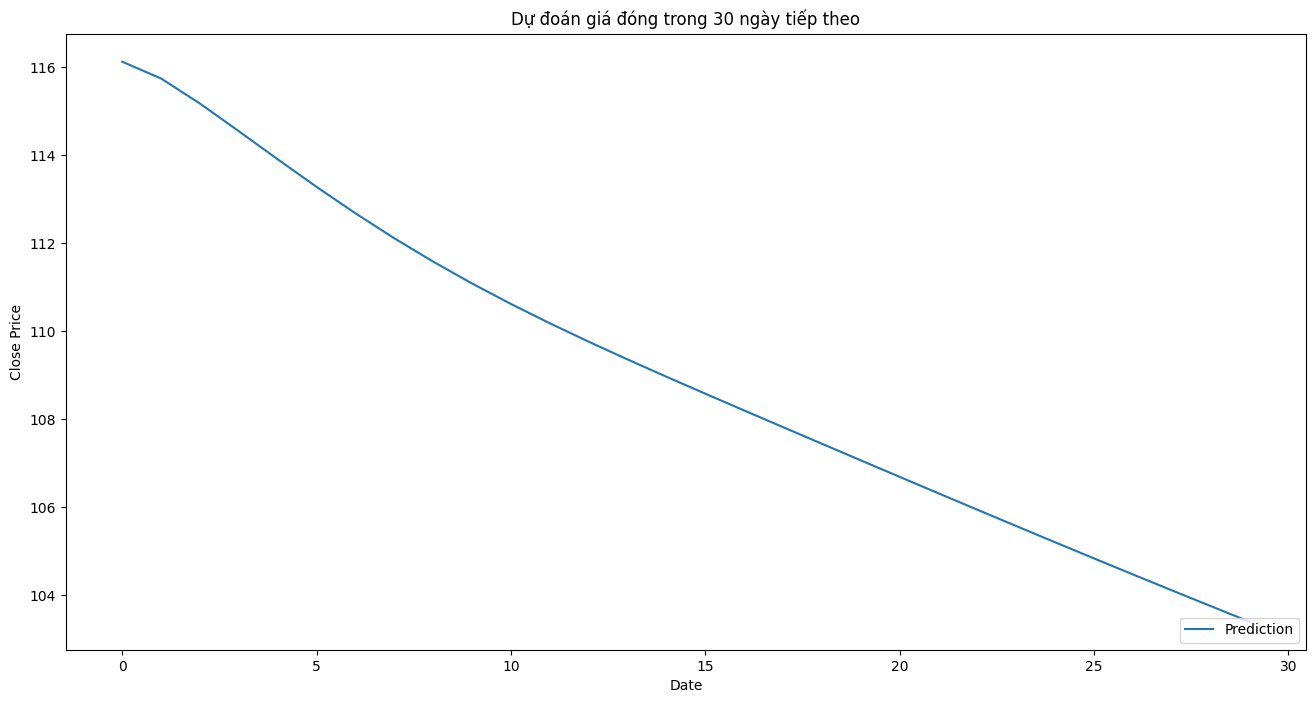

In [33]:
plt.figure(figsize=(16,8))
plt.title('Dự đoán giá đóng trong 30 ngày tiếp theo')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(y_future_pred)
plt.legend(['Prediction'], loc='lower right')
plt.show()



*   Biểu đồ 1



<ipython-input-58-96f0e5e6e624>:16: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



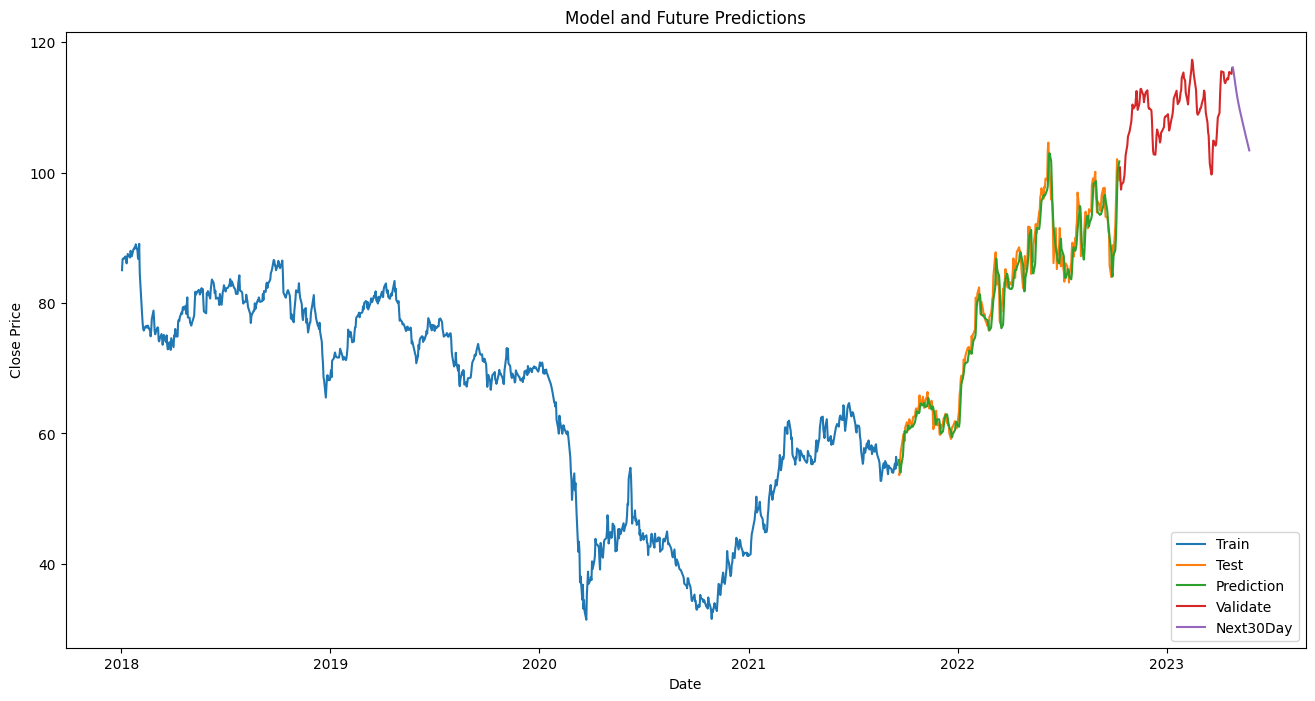

In [58]:
plt.figure(figsize=(16, 8))
plt.title('Model and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Vẽ biểu đồ cho dữ liệu huấn luyện
plt.plot(train, label='Train')

# Vẽ biểu đồ cho dữ liệu validation (thực tế và dự đoán)
plt.plot(test[['Close', 'Predictions']], label=['Test', 'Prediction'])

# Vẽ biểu đồ cho dữ liệu test (thực tế và dự đoán)
plt.plot(validation[['Predictions']], label='Validate')

# Tạo mảng ngày tiếp theo
next_30_days = pd.date_range(start=data.index[-1], periods=31, closed='right')

# Vẽ biểu đồ cho dự đoán 30 ngày tiếp theo
plt.plot(next_30_days, y_future_pred, label='Next30Day')

plt.legend(loc='lower right')
plt.show()




*   Biểu đồ 2



In [35]:
x_train_ind = list(range(0, train_size))
x_test_ind = list(range(train_size, train_size+test_size))
x_validation_ind = list(range(train_size+test_size, len(values)))
pred_ind = list(range(len(values), len(values)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train_ind, y=train['Close'], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=x_test_ind,y=test['Close'], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=x_test_ind,y=test['Predictions'], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=x_validation_ind, y=validation['Predictions'], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=pred_ind, y=y_future_pred.reshape(-1), mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#9569BE'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'XOM LSTM data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()



*   Kiểm tra giá trị close dự đoán cho ngày thứ 30



In [36]:
last_prediction = y_future_pred[-1]
print(last_prediction)

[103.39721]


*Cách 2*

In [38]:
len(validation_data)

195

In [43]:
#Getting the last 60 days records
fut_inp = validation_data[len(validation_data)-60:]

In [44]:
fut_inp = fut_inp.reshape(1,-1)

In [45]:
tmp_inp = list(fut_inp)

In [46]:
fut_inp.shape

(1, 60)

In [47]:
#Creating list of the last 60 data
tmp_inp = tmp_inp[0].tolist()

In [48]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=60
i=0
while(i<30):
    
    if(len(tmp_inp)>60):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.965289294719696], [0.9609366059303284], [0.9544343948364258], [0.9472765922546387], [0.9399973154067993], [0.9328544735908508], [0.9260050654411316], [0.9195372462272644], [0.9134809374809265], [0.9078229665756226], [0.9025202989578247], [0.8975147008895874], [0.8927429914474487], [0.888144850730896], [0.8836678266525269], [0.8792707920074463], [0.8749222159385681], [0.8706018328666687], [0.8662977814674377], [0.8620051741600037], [0.8577231764793396], [0.8534547090530396], [0.8492035865783691], [0.8449738621711731], [0.8407694697380066], [0.8365932703018188], [0.8324469923973083], [0.828331470489502], [0.8242465853691101], [0.8201916217803955]]


In [49]:
len(scaled_data)

1337

In [50]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

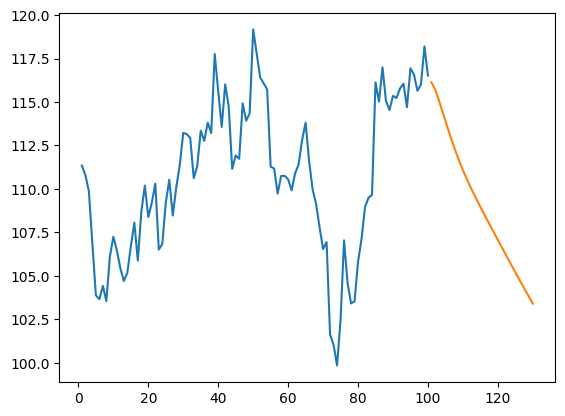

In [51]:
plt.plot(plot_new, scaler.inverse_transform(np.array(scaled_data[len(scaled_data)-100:]).reshape(-1, 1)))
plt.plot(plot_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)))

In [52]:
ds_new = scaled_data.tolist()

In [53]:
len(ds_new)

1337

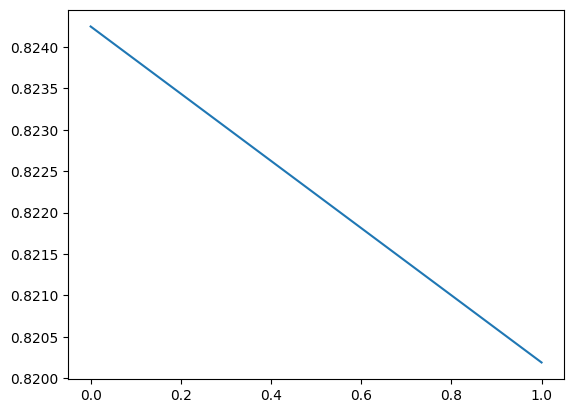

In [54]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[len(ds_new)-2:])

In [55]:
#Creating final data for plotting
final_graph = scaler.inverse_transform(np.array(ds_new).reshape(-1, 1)).tolist()

In [56]:
len(final_graph)

1367

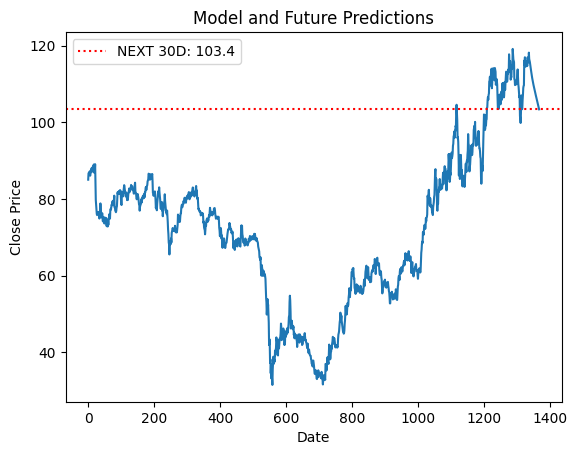

In [57]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.title('Model and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()